In this notebook we attempt to fully reconstruct the behavioral experience of each fly. We use G3S to predict whether the fly is walking or paused, G4S to predict its walking speed during walking epochs, and G4D to predict its angular velocity or the air tube velocity.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression

from aux import make_extended_predictor_matrix
from data import DataLoader
%aimport lin_fit
from plot import set_font_size

import CONFIG as C

In [2]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [3]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
no_air_mask = [trial.expt == 'no_air' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'no_air': 'r'}

colors = [c_dict[trial.expt] for trial in trials]

In [4]:
def get_trial(name):
     return trials[[trial.name for trial in trials].index(name)]

In [5]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx=0, vel_filt=None)

Loading data for trial 1/44 (20170310.Fly2.6)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/44 (20170310.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/44 (20170310.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/44 (20170313.Fly1.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/44 (20170313.Fly1.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 6/44 (20170313.Fly1.3)
Loading clean data from file "clean_0.csv"...
Loading data for trial 7/44 (20170313.Fly1.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 8/44 (20170313.Fly1.8)
Loading clean data from file "clean_0.csv"...
Loading data for trial 9/44 (20170313.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 10/44 (20170313.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 11/44 (20170313.Fly3.3)
Loading clean data from file "cl

### Perform fits for reconstructing trials

In [6]:
WINDOWS = {
    'state': {'g3s': (-1, 2)},
    'speed': {'g4s': (-1, 2)},
    'v_ang': {'g4d': (1, 6)},
    'v_air': {'g4d': (1, 6)},
}

rcn_rslts = {trial.name: lin_fit.reconstruct(trial, WINDOWS) for trial in trials}

/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if valid == 'all':
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:145: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif valid == 'none':
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:203: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.r2s[key] = (np.nanvar(ys[key]) - np.nanvar(self.errs[key])) / np.nanvar(ys[key])


In [7]:
def plot_example_rcn(trial):
    """Plot the reconstruction results for an example trial."""
    rcn_rslt = rcn_rslts[trial.name]
    ts = trial.dl.t
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 12), tight_layout=True)
    
    # speed
    axs[0].plot(ts, rcn_rslt.ys['speed'], color='k')
    axs[0].plot(ts, rcn_rslt.ys_pred['speed'], color='m')

    axs[0].set_ylabel('speed')
    
    # v_ang
    axs[1].plot(ts, rcn_rslt.ys['v_ang'], color='k')
    axs[1].plot(ts, rcn_rslt.ys_pred['v_ang'], color='m')

    axs[1].set_ylabel('v_ang')
    
    # air tube
    if trial.expt != 'no_air':
        axs[2].plot(ts, rcn_rslt.ys['v_air'], color='k')
        axs[2].plot(ts, rcn_rslt.ys_pred['v_air'], color='m')
        
    axs[2].set_ylabel('v_air')
    
    for ax in axs:
        ax.set_xlim(ts[0], ts[-1])
        ax.set_xlabel('t (s)')
        set_font_size(ax, 16)
        
    return axs

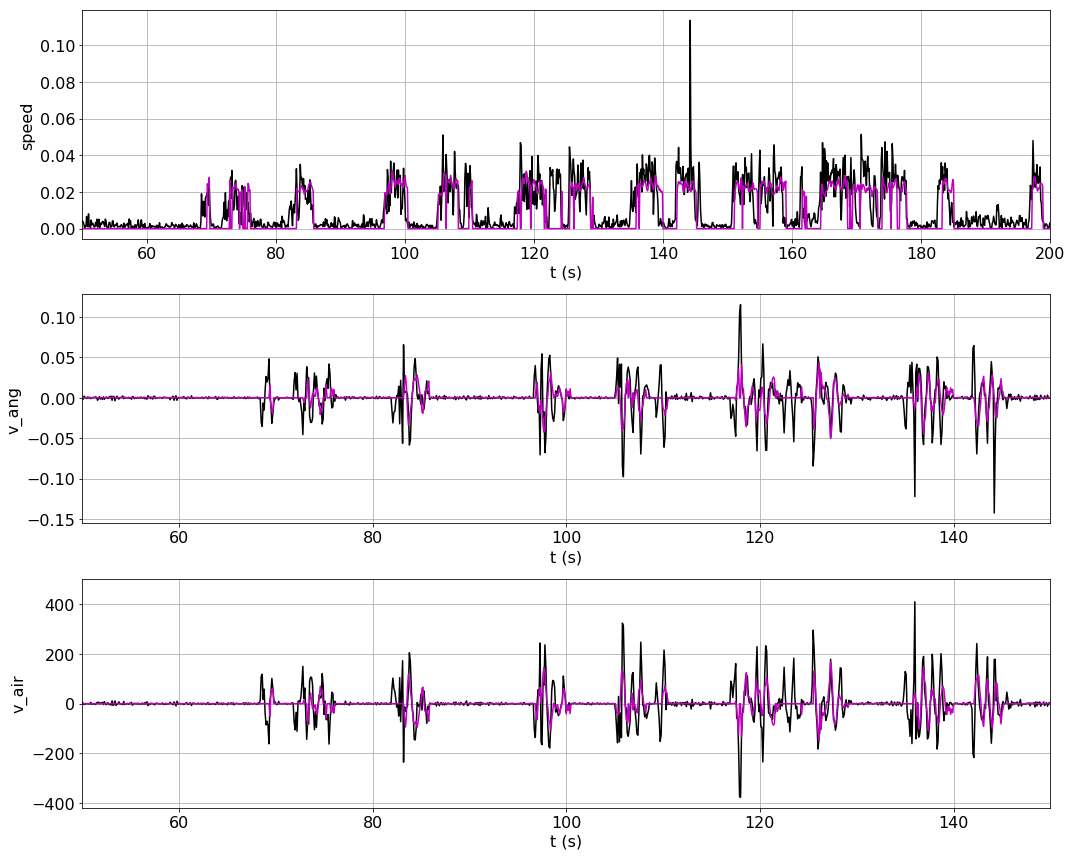

In [8]:
axs = plot_example_rcn(get_trial('20170428.Fly5.1'))

axs[0].set_xlim(50, 200)
axs[1].set_xlim(50, 150)
axs[2].set_xlim(50, 150)

for ax in axs:
    ax.grid()

### Table of prediction R2s for speed, v_ang, and air_tube

In [9]:
df_data = []

for trial in trials:
    rcn_rslt = rcn_rslts[trial.name]
    
    df_data_ = {'trial': trial.name, 'expt': trial.expt}
    df_data_['speed'] = rcn_rslt.r2s['speed']
    df_data_['v_ang'] = rcn_rslt.r2s['v_ang']
    
    if trial.expt != 'no_air':
        df_data_['v_air'] = rcn_rslt.r2s['v_air']
        
    df_data.append(df_data_)
    
cols = ['trial', 'expt', 'speed', 'v_ang', 'v_air']

df = pd.DataFrame(df_data, columns=cols)
df

,trial,expt,speed,v_ang,v_air
0,20170310.Fly2.6,closed_loop,0.147328,0.070515,0.070854
1,20170310.Fly3.1,closed_loop,0.156964,0.094697,0.093375
2,20170310.Fly3.2,closed_loop,0.175216,0.160814,0.159372
3,20170313.Fly1.1,closed_loop,0.200855,0.132180,0.133594
4,20170313.Fly1.2,closed_loop,0.077409,0.152242,0.150491
5,20170313.Fly1.3,closed_loop,0.021735,0.196583,0.195702
6,20170313.Fly1.4,closed_loop,0.082233,0.268289,0.265563
7,20170313.Fly1.8,closed_loop,0.017951,0.176377,0.172307
8,20170313.Fly3.1,closed_loop,0.123056,0.195212,0.197093
9,20170313.Fly3.2,closed_loop,0.247535,0.318497,0.320219


### Correlation table of prediction R2s

In [10]:
df.corr()

,speed,v_ang,v_air
speed,1.000000,0.440813,0.551936
v_ang,0.440813,1.000000,0.766082
v_air,0.551936,0.766082,1.000000


The positive correlations between the predictability of each variable suggests that some flies are generally more predictable from their DAN activities than others.